# Synthetic Direct Images

This notebook creates a synthetic direct image and segmentation map suitable for testing of ```pyLINEAR```.  This uses ```astropy.modeling``` to create parametric sources and ```skimage.morphology``` to determine the segmentation IDs.  

### Notebook was prepared by Russell Ryan Jul. 23, 2020


In [1]:
from astropy.io import fits            # to write the fits files
import numpy as np                     # for general computations
from astropy import wcs                # for the WCS of the output images
from astropy.modeling import models    # to create parametric models
from skimage.morphology import label   # to segment the image
import matplotlib.pyplot as plt        # to visualize 

In [2]:
segfile = 'seg.fits'         # name of output segmentation map
imgfile = 'img.fits'         # name of output direct image
crval = [53.0,-27.0]         # RA,Dec center of nominal field
pixscl = 0.060               # pixel scale (arcsec/pix) of segmentation & image
size = (1000,1000)           # size (pixels) of output images

In [3]:
# create a grid of (x,y) pairs for the images
x,y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

In [4]:
# create the output image
img = np.zeros(size)

In [5]:
# create a bunch of sources
func = models.Gaussian2D(x_stddev = 1.5, y_stddev = 1.5)   # start with basic Gaussian

# do first source
func.x_mean,func.y_mean = 500,500      # put it at the center
func.amplitude = 2.0                   # make it pretty bright
img += func(x,y)                       # evaluate the model

# do second source
func.x_mean,func.y_mean = 520,500      # offset it in x
func.amplitude = 1.0                   # make a tad fainter
img += func(x,y)                       # evaluate the model

# do third source
func.x_mean,func.y_mean = 420,550      # put it all by itself
func.amplitude = 0.5                   # make it fainter still
img += func(x,y)                       # evaluate the model

In [6]:
# create a segmentation map from this image
threshold = 0.2                       # threshold to apply to the image
good = img > threshold                # these pixels belong to a source
seg = label(good)                     # now these pixels have unique segmentation IDs

In [7]:
# create a WCS for the image and segmentation
w = wcs.WCS(naxis=2)                  # the WCS object
w.wcs.crpix = [size[0]/2,size[1]/2]   # put the CRPIX at the center of the image
w.wcs.crval = crval                   # set the RA,Dec of the center
w.wcs.ctype = ['RA---TAN','DEC--TAN'] # use RA,Dec projection
p = pixscl/3600.                      # change units from arcsec/pix to deg/pix
w.wcs.cd = [[-p,0.],[0.,p]]           # set the CD matrix; the neg sign makes E-left

# put the WCS into a fits header
hdr = w.to_header()

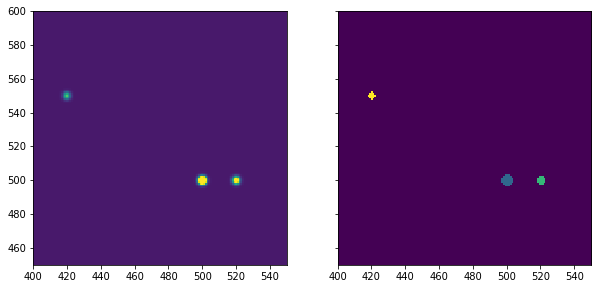

In [8]:
# let's just visualize the images, since we made them

# set the bounding box for where we will zoom to
xmin,xmax = 400,550
ymin,ymax = 450,600

# create a plot window
fig,(p1,p2) = plt.subplots(1,2,figsize=(10,10),sharex=True,sharey=True)
#fig,(p3,p4) = plt.subplots(1,2,figsize=(10,10),sharex=True,sharey=True)

# show the direct image on left, and segmentation on the right
p1.imshow(img,origin='lower',vmin=-0.05,vmax=0.7)
p2.imshow(seg,origin='lower',vmin=0,vmax=3)

# zoom to an interesting region
_ = p1.set_xlim(xmin,xmax)
_ = p1.set_ylim(ymin,ymax)
_ = p2.set_xlim(xmin,xmax)
_ = p2.set_ylim(ymin,ymax)



In [9]:
# write the images to disk
fits.writeto(segfile,seg,header=hdr,overwrite=True) # write the segmap
fits.writeto(imgfile,img,header=hdr,overwrite=True) # write the image

# note, we're using the same header here, but one could put separate data in the 
#       the headers.  This was just a short-cut to ensure the WCS was the same
#       pyLINEAR will throw an error if the WCS for seg and img do not match.